### Bag-of-Words & TF-IDF Matrix
Bag-of-Words (BoW) places all the words of each text into a 'bucket' or 'bag'. Because of this method, information about the stucture of the sentence is lost. 

TF-IDF stands for Term Frequency - Inverse Document Frequency. TF-IDF scores the relative importance of the words, in order to gain an understanding of the texts as a whole. 

The Term Frequency (TF) is the number of times a word appears in the document, divided by the total number of words in the document.

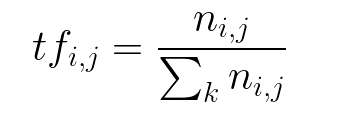

Inverse Document Frequency (IDF) is the log of the number of documents divided by the number of documents that contain a particular word. The IDF finds the weight of rare words across all the documents in the corpus. 

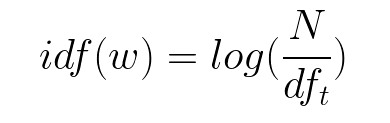

TF-IDF is TF multiplied by IDF. 
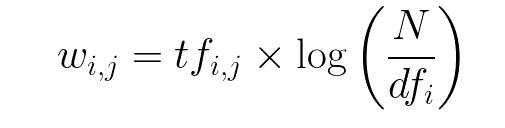

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px

In [2]:
sns.set()
%matplotlib inline

In [26]:
#TFIDF arguments
count_method = 'n' # 'c' or 'n' # n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'YlGnBu'

In [6]:
#set OHCO params
OHCO = ['text_id', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:3]
PARAS = OHCO[:2]
TEXTS = OHCO[:1]

In [7]:
#Texts as bag
bag = TEXTS

In [8]:
#import tables
LIB = pd.read_csv('LIB.csv').set_index(TEXTS)
TOKEN = pd.read_csv('TOKEN.csv').set_index(OHCO)
VOCAB = pd.read_csv('VOCAB.csv').set_index('term_id')
# DOC = pd.read_csv("DOC.csv")

In [19]:
TOKEN.head()

pos_tuple pos token_str  \
text_id para_num sent_num token_num                                     
1       16       0        0             ('Every', 'DT')  DT     Every   
                          1               ('art', 'NN')  NN       art   
                          2               ('and', 'CC')  CC       and   
                          3             ('every', 'DT')  DT     every   
                          4          ('inquiry,', 'NN')  NN  inquiry,   

                                    term_str  term_id  
text_id para_num sent_num token_num                    
1       16       0        0            every    17469  
                          1              art     4390  
                          2              and     3416  
                          3            every    17469  
                          4          inquiry    25045

In [20]:
LIB.head()

,text_title,text_author,text_file
text_id,,,
1,NicomachaenEthics,Aristotle,philostexts\Aristotle_NicomachaenEthics-1.txt
4,OnDuties,Cicero,philostexts\Cicero_OnDuties-4.txt
5,TheOrderofThings,Foucault,philostexts\Foucault_TheOrderofThings-5.txt
6,PedagogyOfTheOppressed,Freire,philostexts\Freire_PedagogyOfTheOppressed-6.txt
7,TheOriginsofTotalitarianism,HannahArendt,philostexts\HannahArendt_TheOriginsofTotalitar...


In [21]:
VOCAB.head()

,term_str,n,num,stop,p_stem,pos_max
term_id,,,,,,
1,0,28,1,0,0,CD
2,00,13,1,0,00,CD
3,01,6,1,0,01,CD
4,011,1,1,0,011,CD
5,013,1,1,0,013,CD


In [14]:
#remove any missing values
VOCAB = VOCAB[~VOCAB.term_str.isna()]
TOKEN = TOKEN[~TOKEN.term_str.isna()]

In [27]:
#add term rank to VOCAB
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

In [28]:
#groups words by term count
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')

VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1
VOCAB['p'] = VOCAB.n / VOCAB.shape[0]

In [29]:
#BOW
BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
BOW['c'] = BOW.n.astype('bool').astype('int')
BOW.head()

n  c
text_id term_id       
1       18       29  1
        19        7  1
        40        7  1
        55        6  1
        79        4  1

In [33]:
#Build count matrix
DTCM = BOW[count_method].unstack().fillna(0).astype('int')
#DTCM.head()

In [39]:
#function to compute TF (Term Frequency)
#group by Bag (TEXT)
def compute_TF(tf_method, DTCM):
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')  
    TF = TF.T  
    return TF

In [38]:
#call function
compute_TF(tf_method, DTCM).head()

term_id,1,2,3,4,5,6,7,8,9,10,...,52115,52116,52117,52118,52119,52120,52121,52122,52123,52124
text_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.000000
2,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00001,0.00001,0.00001,0.00001,0.0,0.0,0.00001,0.00001,0.000019
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.000000


In [43]:
#Function to compute DF (document frequency) and IDF (inverse document frequency)

def compute_IDF(DTCM, idf_method):
    #compute DF 
    DF = DTCM[DTCM > 0].count()
    N = DTCM.shape[0] #define shape of matrix
    
    #compute IDF
    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1 
    
    return IDF 

In [51]:
compute_IDF(DTCM, idf_method).head()

term_id
1    0.823909
2    1.000000
3    1.301030
4    1.301030
5    1.301030
dtype: float64

In [48]:
#compute TF-IDF (term frequency–inverse document frequency)
def compute_TFIDF(TF, IDF):
    TFIDF = TF * IDF
    return TFIDF 

In [47]:
compute_TFIDF(TF, IDF).head()

term_id,1,2,3,4,5,6,7,8,9,10,...,52115,52116,52117,52118,52119,52120,52121,52122,52123,52124
text_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2,0.000011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000013,0.000013,0.000013,0.000013,0.0,0.0,0.000013,0.000013,0.000025
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
